In [1]:
import numpy as np
np.random.seed(12345)
from scipy.special import erfinv
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('./hda.mplstyle')
plt.rcParams["text.usetex"] = False
%matplotlib inline

from itertools import product
from tqdm import tqdm

## Solve equations

The point is to find out where $h(x)$ and $v(x)$ intersect (for the first and only time):

$h(x) = 2f_1(1+x)$

$v(x) = exp[x(2f_2/f_1)]$

Let us plot the functions first, for some example data, following the screenshot of the Excel application, provided by Chao et al:

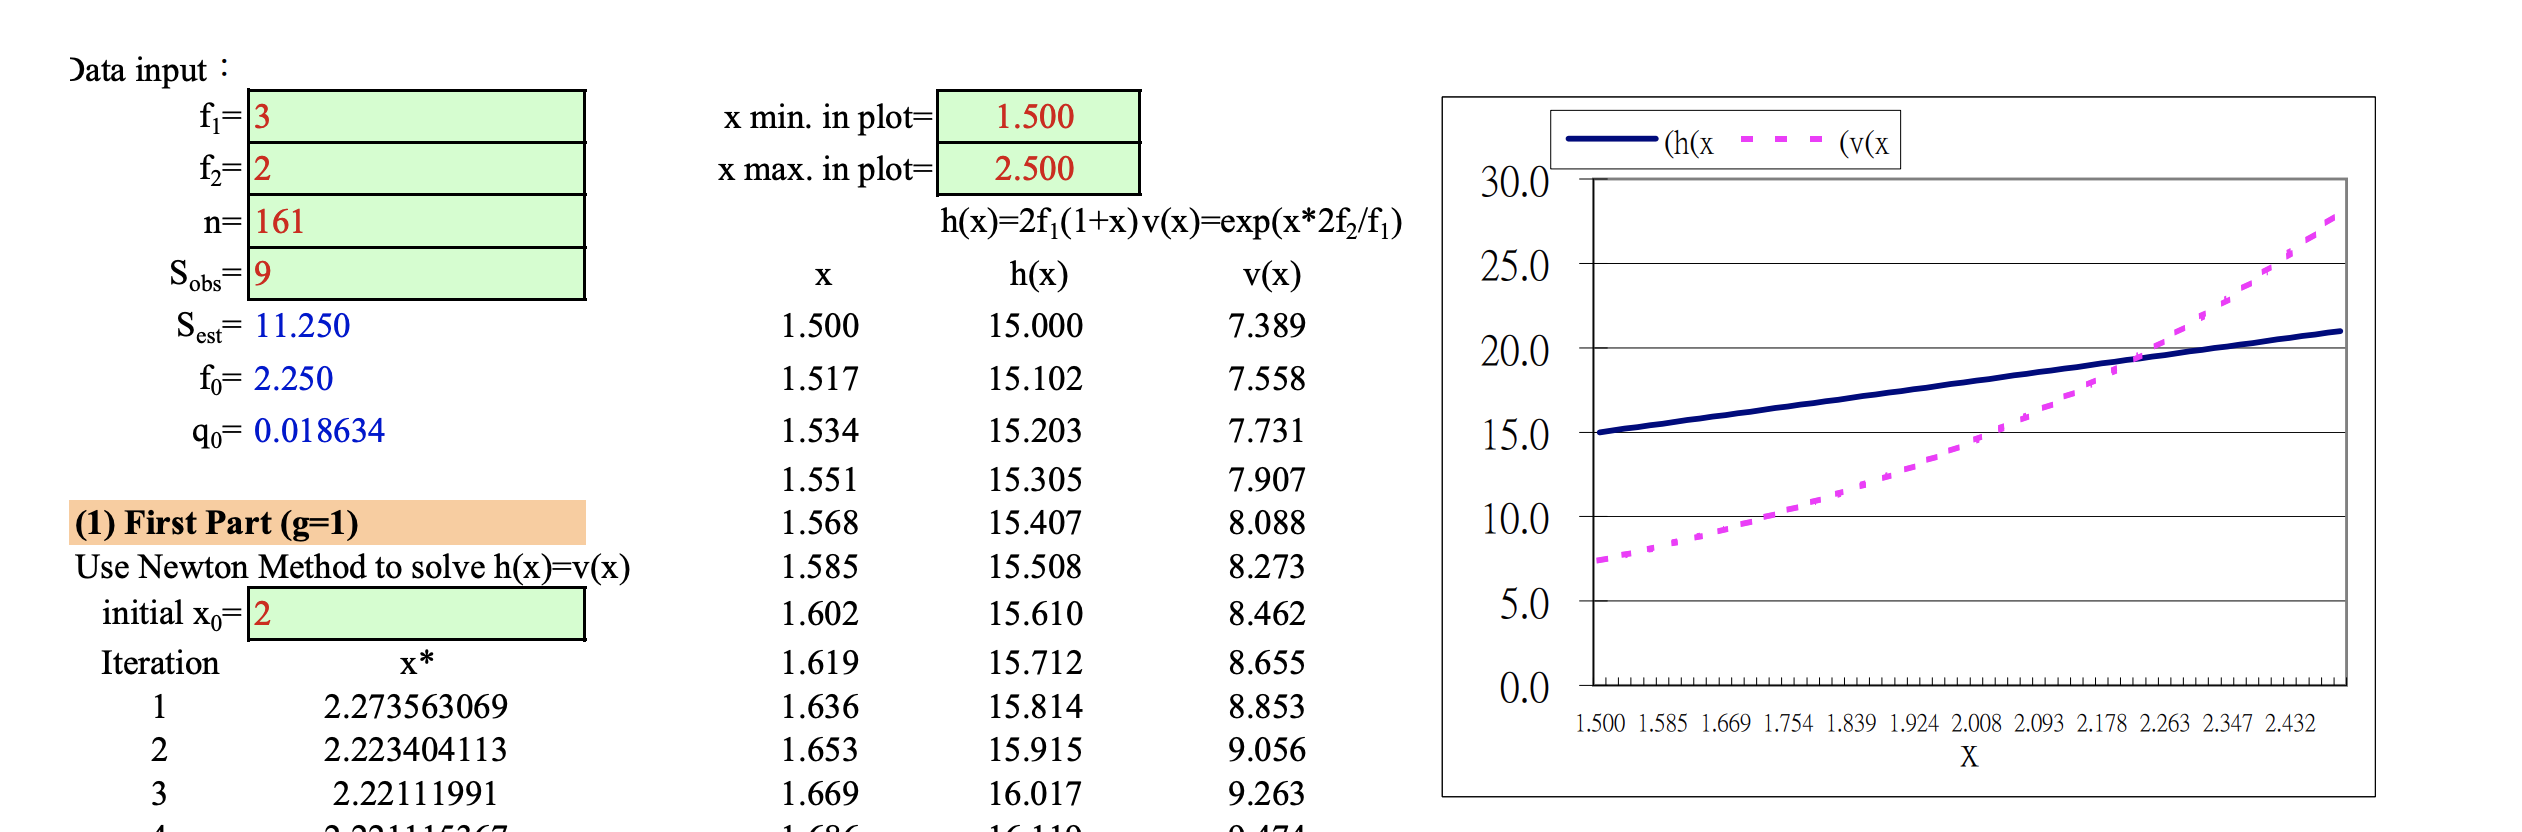

In [2]:
from IPython.display import Image
Image(filename='ex_curve.png')

In [3]:
f1 = 3
f2 = 2
n = 161

In [4]:
x = np.linspace(0, 2.5, 100)

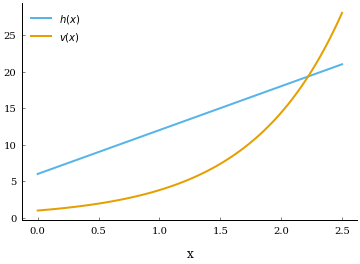

In [5]:
plt.plot(x, 2 * f1 * (1 + x), label='$h(x)$')
plt.plot(x, np.exp(x * (2 * f2 / f1)), label='$v(x)$')
plt.xlabel('x')
plt.legend();

We need to find out where these two lines intersect:

In [6]:
from scipy.optimize import fsolve

def intersection(func1, func2, x0):
    return fsolve(lambda x: func1(x) - func2(x), x0)[0]

h = lambda x: 2 * f1 * (1 + x)
v = lambda x: np.exp(x * (2 * f2 / f1))

We set $x0$ (the starting point for the Newton optimization) pragmatically to $n$:

In [7]:
x_ast = intersection(h, v, n)

Then, following the $m=nx*$:

In [8]:
m = n * x_ast
m

357.5995740985314

We would have to sample ~357+ additional individuals to observe all the unobserved biota.

## (Empirische) Data

In [9]:
mnl = pd.read_excel('mnl.xlsx', header=None, names=('text', 'witness'))
mnl.head(10)

,text,witness
0,Aiol (1),H1
1,Aiol (2),H2
2,Alexanders Geesten,"München, Bayerische Staatsbibliotheek, Cod. ge..."
3,Alexanders Geesten,H3
4,Alexanders Geesten,H4
5,Alexanders Geesten,H5
6,Alexanders Geesten,H6
7,Arturs doet,"Den Haag, KB, 129 A 10"
8,Arturs doet,"Rijksarchief te Antwerpen, Sint-Catharinakapit..."
9,Aubri de Borgengoen,H7


In [10]:
cnts = mnl.groupby('text').size().sort_values(ascending=False).values
cnts

array([16, 10, 10,  7,  6,  5,  5,  5,  4,  4,  4,  3,  3,  3,  3,  3,  3,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1])

In [11]:
f1 = np.sum(cnts == 1)
f2 = np.sum(cnts == 2)
n = cnts.sum()
f1, f2, n

(42, 13, 162)

In [12]:
h = lambda x: 2 * f1 * (1 + x)
v = lambda x: np.exp(x * (2 * f2 / f1))

x_ast = intersection(h, v, n)
m_mnl = n * x_ast
m_mnl

1814.0740588430901

## As before

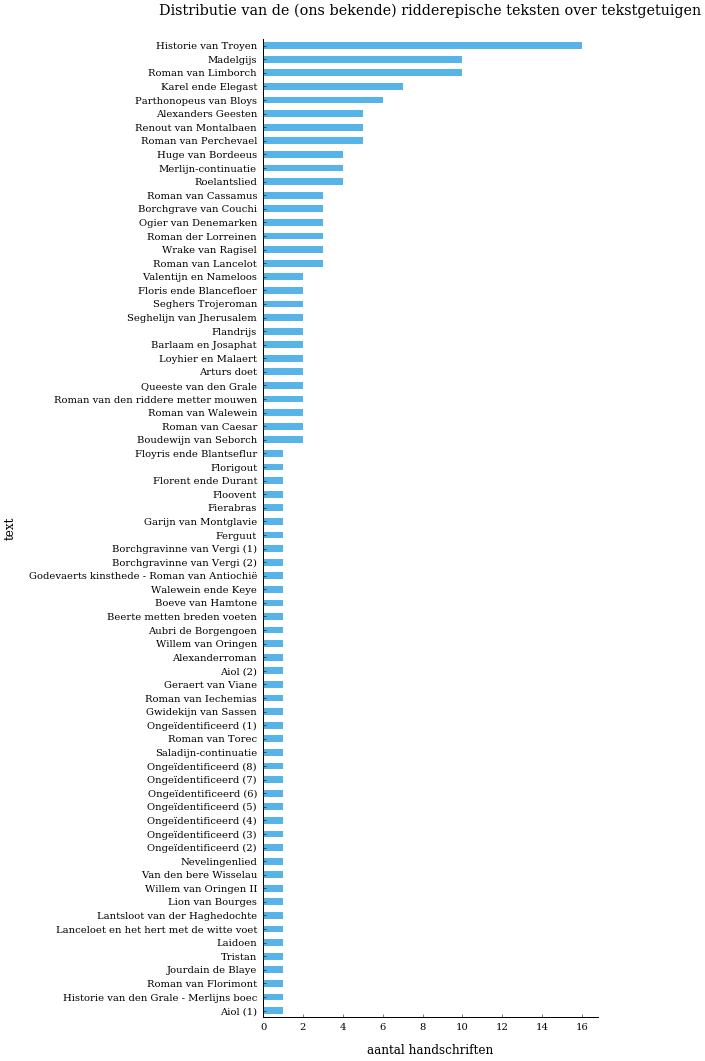

In [13]:
plt.figure(figsize=(6,18))
mnl.groupby('text').size().sort_values(ascending=True).plot.barh(ax=plt.gca());
plt.xlabel('unieke teksten')
plt.xlabel('aantal handschriften')
plt.title('Distributie van de (ons bekende) ridderepische teksten over tekstgetuigen')
plt.savefig('histogram.tiff')

In [14]:
def species_richness(counts):
    return np.sum(counts > 0)

print('# unieke teksten:', species_richness(mnl.groupby('text').size()))
print('# unieke handschriften:', len(mnl))
print('ratio:', len(mnl) / species_richness(mnl.groupby('text').size()))

# unieke teksten: 72
# unieke handschriften: 162
ratio: 2.25


Een alternatief perspectief op de distributie:

In [15]:
types = mnl.groupby('text').size().sort_values(ascending=False).value_counts().sort_index()
types = types.to_frame(name='aantal teksten')
types['aantal handschriften'] = types.index

from IPython.display import display, HTML
display(HTML(types.to_html(index=False)))

aantal teksten,aantal handschriften
42,1
13,2
6,3
3,4
3,5
1,6
1,7
2,10
1,16


## Chao (with bootstrap)

Basisformule, gebaseerd op 1-tjes en 2-tjes:

In [16]:
def chao_richness(x):
    x, n = x[x > 0], x.sum()
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    return t + (n - 1) / n * ((f1 ** 2 / 2 / f2) if f2 > 0 else (f1 * (f1 - 1) / 2))

In [17]:
def chao_min_sample(x):
    x, n = x[x > 0], x.sum()
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    h = lambda x: 2 * f1 * (1 + x)
    v = lambda x: np.exp(x * (2 * f2 / f1))
    x_ast = intersection(h, v, n)
    return n * x_ast

Asymptotic richness estimate:

In [18]:
chao_richness(cnts)

139.4273504273504

Minimum additional sampling effort required to observe these:

In [19]:
chao_min_sample(cnts)

1814.0740588430901

Monsteringsproces om variantie in kaart te brengen:

In [20]:
def bt_prob(x):
    x, n = x[x > 0], x.sum()
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    C = 1 - f1 / n * (((n - 1) * f1 / ((n - 1) * f1 + 2 * f2)) if f2 > 0 else
                      ((n - 1) * (f1 - 1) / ((n - 1) * (f1 - 1) + 2)) if f1 > 0 else
                      0)
    W = (1 - C) / np.sum(x / n * (1 - x / n) ** n)
    p = x / n * (1 - W * (1 - x / n) ** n)
    f0 = np.ceil(((n - 1) / n * f1 ** 2 / (2 * f2)) if f2 > 0 else
                 ((n - 1) / n * f1 * (f1 - 1) / 2))
    p0 = (1 - C) / f0
    p = np.hstack((p, np.array([p0 for i in np.arange(f0)])))
    return p


def bootstrap(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    pro = np.array([fn(row) for row in data_bt])
    
    pro_mean = pro.mean(0)
    
    lci_pro = -np.quantile(pro, (1 - conf) / 2, axis=0) + pro_mean
    uci_pro = np.quantile(pro, 1 - (1 - conf) / 2, axis=0) - pro_mean

    sd_pro = np.std(pro, axis=0)

    pro = pro_mean - pro
    return (lci_pro, uci_pro, sd_pro, pro)

In [21]:
def chao_estimate(x, n_iter=1000, conf=0.95):
    pro = chao_richness(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=chao_richness, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [22]:
def sampling_estimate(x, n_iter=1000, conf=0.95):
    pro = chao_min_sample(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=chao_min_sample, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [23]:
lci_pro, uci_pro, bt_pro, pro = chao_estimate(cnts, n_iter=10000)
print('pro:', pro)
print('lci_pro:', lci_pro)
print('uci_pro:', uci_pro)

pro: 139.4273504273504
lci_pro: 101.33822651084985
uci_pro: 207.0890184211812


In [24]:
lci_pro_sample, uci_pro_sample, bt_pro_sample, pro_sample = sampling_estimate(cnts, n_iter=10000)
print('pro:', pro_sample)
print('lci_pro:', lci_pro_sample)
print('uci_pro:', uci_pro_sample)

/Users/mikekestemont/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


pro: 1814.0740588430901
lci_pro: 917.7561304639015
uci_pro: 3651.8313441045516


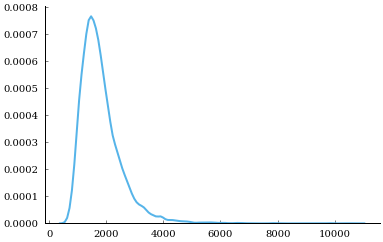

In [25]:
from seaborn import kdeplot
kdeplot(bt_pro_sample)

In [288]:
bt_pro_sample

array([1366.09868135, 1825.97632837, 1946.77082793, ..., 1627.77122852,
       1031.36343288, 1988.20165349])

In [26]:
import ptitprince as pt
import seaborn as sns

d = list([(x, 'bt') for x in bt_pro])
bt = pd.DataFrame(d, columns=('bt', 'type'))

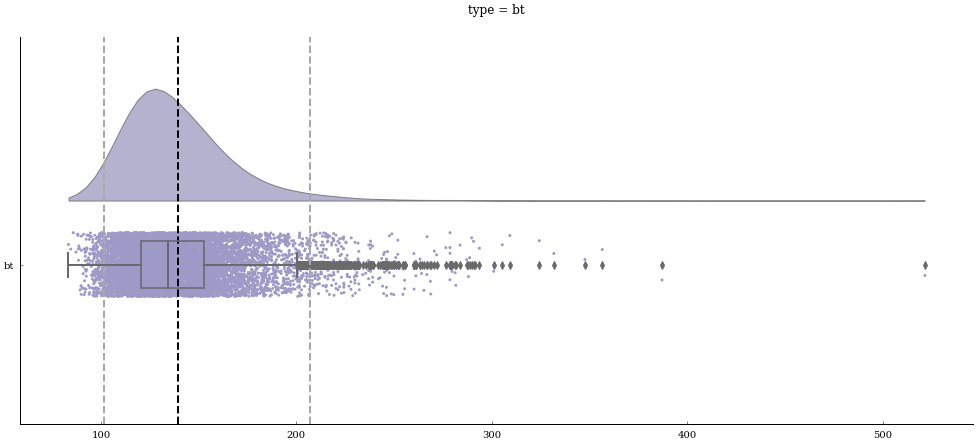

In [27]:
g = sns.FacetGrid(bt, col="type", sharey=False, aspect=1.5)
g = g.map_dataframe(pt.RainCloud, x="type", y="bt", data=bt, palette='Purples',
                    orient="h", ax=g.axes, alpha=.8, bw=.3, width_viol=0.7)

g.fig.set_size_inches(15, 8)

plt.gca().axvline(pro, c='black', ls='--');
plt.gca().axvline(uci_pro, c='darkgrey', ls='--');
plt.gca().axvline(lci_pro, c='darkgrey', ls='--');

Het idee dat er minstens 100 teksten waren is geen statistische larie, maar het is een wel erg conservatieve schatting, helemaal onderin het probabiliteitscontinuum. Veel meer aannemelijk is de schatting can ~140 manuscripten (of meer), wat zou betekenen dat *minstens de helft van de ridderepische teksten niet is overgeleverd*. Net zoals 100 een uiterst optimistische schatting is, vormt ~216 de meest pessimistische schatting die we op dit moment kunnen voorop stellen: in dat geval, zou ons slechts een derde van de ooit beschikbare ridderepiek zijn overgeleverd, hetgeen al meer dramatische, maar niet geheel onrealistische cijfers zijn.

In [28]:
x = cnts

In [29]:
import scipy.stats as stats
from scipy.special import gammaln

def bootstrap_re(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    Dq = fn(x)
    
    pro = np.array([fn(row) for row in data_bt])
    
    error = stats.norm.ppf(1 - (1 - conf) / 2) * np.std(pro, 0)
    lci_pro = Dq - error
    uci_pro = Dq + error

    sd_pro = np.std(pro, axis=0)

    return (lci_pro, uci_pro, sd_pro, Dq, )


def rarefaction_extrapolation(x, max_steps):
    x, n = x[x > 0], x.sum()
    def _sub(m):
        if m <= n:
            return np.sum(1 - np.array(
                [np.exp(gammaln(n - i + 1) + gammaln(n - m + 1) - 
                        gammaln(n - i - m + 1) - gammaln(n + 1)) if i <= (n - m) else
                 0 for i in x]))
        else:
            S = (x > 0).sum()
            f1, f2 = (x == 1).sum(), (x == 2).sum()
            f0 = ((n - 1) / n * f1 * (f1 - 1) / 2) if f2 == 0 else ((n - 1) / n * f1**2 / 2 / f2)
            A = n * f0 / (n * f0 + f1)
            return S if f1 == 0 else (S + f0 * (1 - A**(m - n)))
    return np.array([_sub(mi) for mi in range(1, max_steps)])

In [30]:
from functools import partial
num_ms = x.shape[0] + int(m_mnl) # n + m
lci_pro, uci_pro, sd_pro, Dq = bootstrap_re(x, fn=partial(rarefaction_extrapolation, max_steps=num_ms), n_iter=50)

/Users/mikekestemont/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:323: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


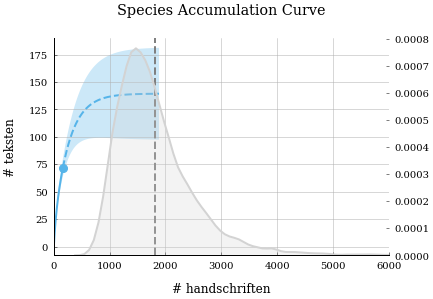

In [31]:
steps = np.arange(1, num_ms)
interpolated = np.arange(1, num_ms) < x.sum()
plt.plot(steps[interpolated], Dq[interpolated], color='C0')
plt.plot(x.sum(), Dq[x.sum() - 1], 'o')
plt.plot(steps[~interpolated], Dq[~interpolated], '--', color='C0')
plt.fill_between(steps, lci_pro, uci_pro, alpha=0.3)
plt.grid()
plt.axvline(np.mean(bt_pro_sample), ls='--', c='grey')
plt.xlabel('# handschriften')
plt.ylabel('# teksten')
plt.title('Species Accumulation Curve')
ax2 = plt.gca().twinx()
kdeplot(bt_pro_sample, ax=ax2, c='lightgrey', shade=True)
plt.xlim([0, 6000])
plt.savefig('accumulation.jpg')